In [19]:
#import necessary modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import re


# files

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [20]:
#import dataset 
df = pd.read_csv(r'C:/Users/foeke/OneDrive/Documenten/submitting paper/All scripts - paper/data/GlobalModelData/PredictingDataset.csv', sep=',')
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df

,Unnamed: 0,Longitude,Latitude,mean_value_NO2,nightlight_450,nightlight_3150,population_1000,population_3000,road_class_2_25,road_class_3_3000,road_class_3_300,trop_mean_filt_2019,BldDen100,NDVI,trafBuf25,trafBuf50
0,0,10.008293,48.397079,29.250500,22.585377,13.402575,8123.319336,54316.64453,0.000000,203502.42190,4167.064941,0.000058,1.000663,2310.0,0.000000,0.000000
1,1,10.021227,53.523262,32.098936,23.546194,22.862799,9558.207031,76786.28125,0.000000,99596.04688,1850.278076,0.000081,0.978245,2518.0,0.000000,0.000000
2,2,10.053859,53.592301,58.703744,18.290140,16.493486,10471.541020,88439.60938,46.359188,265563.71880,2016.838379,0.000076,0.914638,3216.0,674.791667,674.791667
3,3,10.081685,53.529020,24.249276,23.645823,18.248226,11165.945310,76961.00000,0.000000,97921.56250,478.363281,0.000074,0.712983,1052.0,0.000000,0.000000
4,4,10.096292,48.847917,19.912116,14.026642,5.514785,6017.511230,30814.58984,0.000000,176265.68750,3338.221191,0.000047,1.000641,3240.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,477,9.979031,48.396836,27.221808,29.130899,12.865678,10829.854490,54732.38281,0.000000,198280.70310,3127.346436,0.000058,0.964609,2607.0,0.000000,0.000000
478,478,9.981599,53.529158,32.763475,33.719387,36.813637,9855.304688,83610.52344,0.000000,117941.50000,1480.759766,0.000088,1.000696,NaN,0.000000,0.000000
479,479,9.990569,53.507930,24.966811,17.919800,25.516184,9541.226562,76877.67188,0.000000,94117.64063,2670.007568,0.000082,0.485096,4338.0,0.000000,0.000000
480,480,9.997256,53.681993,39.256824,13.382681,7.228415,7302.048828,44593.98438,54.294807,171093.43750,2462.917969,0.000063,1.000694,4006.0,674.791667,674.791667


## Data processing

In [21]:
#remove geodata
df = df.drop(['Unnamed: 0', 'Longitude', 'Latitude'], axis=1)

#remove NAs and replace with 0
df=df.fillna(0)

y = df['mean_value_NO2'] #target
x = df.drop(['mean_value_NO2'], axis=1) #predictors
feature_list = list(x.columns)

In [22]:
#models

#Non-linear

#Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, min_samples_split=10,
                          min_samples_leaf=5,max_features=4,max_depth=10, bootstrap=True )

#LightGBM
lightgbm_model = lgb.LGBMRegressor(reg_alpha =2, reg_lambda = 0, max_depth = 5, learning_rate = 0.0005, n_estimators =50000, random_state=42)
#XGBoost
xgb= xgb.XGBRegressor(gamma = 5,  reg_alpha =2, reg_lambda=0, max_depth = 5, learning_rate = 0.0005, n_estimators=50000, random_state=42)


#linear models

#Lasso
model_lasso = Lasso(alpha=0.1)
#Ridge
ridge2 = Ridge(alpha = 0.3)


In [23]:
#random states - CV = 20
random_states = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] #random state is needed to ensure that same results are generated each time.
#models
models = [rf, lightgbm_model, xgb, model_lasso, ridge2]
#model_names
model_names = ['rf', 'lgb', 'xgb', 'lasso', 'ridge']

In [24]:
#construct cross-validation via loop

#create dictionaries that eventually stores performance per model (CV)
total_rmse = {}
total_r2 = {}
total_mae = {}

rmse_vals_round = []
#start with first model
for i,k in zip(models,model_names):
    #initialize lists where performances can be stored to
    locals()[str(k)+"RMSE_scores"] = []
    locals()[str(k)+"R2_scores"] = []
    locals()[str(k)+"MAE_scores"] = []
    print(" ")
    print("next model:", str(k))
    print(" ")
#     for j in range(0, len(random_states)):
    for j in random_states:    
        #split dataset into training- and testing dataset
        X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=j)
        print(j)
        #train the model
        i.fit(X_train, Y_train)
#         print(X_train)
        
        #predict based on the training data
        preds_test = i.predict(X_test)
       
    
        ##RMSE
        #create function that calculates RMSE
        def rmse(predictions, targets):
            return np.sqrt(((predictions - targets) ** 2).mean())

        print('RMSE testing: ', rmse(preds_test, Y_test))
        rmse_val = rmse(preds_test, Y_test)
        #store result to list
        locals()[str(k)+"RMSE_scores"].append(rmse_val)
        
    
        ##R2
        print('R2 score testing: ', r2_score(Y_test, preds_test))
        r2_val = r2_score(Y_test, preds_test)
        #store result to list
        locals()[str(k)+"R2_scores"].append(r2_val)
    
        ##MEAN ABSOLUTE ERROR 
        print('MAE testing: ', mean_absolute_error(Y_test, preds_test))
        mae_val = mean_absolute_error(Y_test, preds_test)
        #store result to list
        locals()[str(k)+"MAE_scores"].append(mae_val)

    #store to dictionary
    total_rmse[k] = locals()[str(k)+"RMSE_scores"]
    total_r2[k] = locals()[str(k)+"R2_scores"]
    total_mae[k] = locals()[str(k)+"MAE_scores"]


 
next model: rf
 
1
RMSE testing:  6.4610896984544945
R2 score testing:  0.6994221428650933
MAE testing:  4.625926669509603
5
RMSE testing:  6.654373816151249
R2 score testing:  0.7667136993123488
MAE testing:  4.767613780656911
10
RMSE testing:  6.549017645224474
R2 score testing:  0.7044980464600284
MAE testing:  4.723503232130336
15
RMSE testing:  8.252973274881956
R2 score testing:  0.6449145066950697
MAE testing:  5.744435958478335
20
RMSE testing:  7.7274381581081375
R2 score testing:  0.6736700230316868
MAE testing:  5.570951647522141
25
RMSE testing:  7.66194652172493
R2 score testing:  0.6527255672934432
MAE testing:  5.425343108809896
30
RMSE testing:  6.089531418828927
R2 score testing:  0.7556934658131746
MAE testing:  4.32498908898097
35
RMSE testing:  5.769899751704938
R2 score testing:  0.7819140892547365
MAE testing:  4.102509313707015
40
RMSE testing:  7.365005970781685
R2 score testing:  0.6611276176450603
MAE testing:  5.413524731330514
45
RMSE testing:  6.869328095

In [25]:
#examine
print(total_rmse)
print(total_r2)
print(total_mae)

{'rf': [6.4610896984544945, 6.654373816151249, 6.549017645224474, 8.252973274881956, 7.7274381581081375, 7.66194652172493, 6.089531418828927, 5.769899751704938, 7.365005970781685, 6.869328095601385, 7.595382834064505, 7.1785581766480515, 6.86126389249909, 7.434268234376639, 6.145201679716776, 6.581079218082541, 6.711962023159544, 6.650808194607422, 7.312030467590125, 7.053604049132621], 'lgb': [6.976767444197125, 7.020956917123351, 6.6647980000655975, 8.408098599204575, 7.763328742160422, 8.218780723852378, 6.619006466024785, 6.092605052120545, 7.347988460544557, 6.758133048339935, 8.025395800445626, 7.796298296015083, 7.113726927292045, 7.195796377171202, 6.5324127399876355, 6.887649679159873, 7.293781882466139, 6.525792877968878, 7.988434302876868, 7.418978740149511], 'xgb': [6.771910805653271, 6.709462029982513, 7.1337236706990925, 8.359184313886676, 8.005180129544632, 8.328526775708525, 7.172553781839787, 5.666452739359818, 6.864860649991118, 6.834553268188327, 7.979711500022317, 7

In [26]:
#convert to pandas dataframes
df_total_rmse = pd.DataFrame(total_rmse)
df_total_r2 = pd.DataFrame(total_r2)
df_total_mae = pd.DataFrame(total_mae)

#examine cross-validation root mean square error per model
df_total_rmse.describe()
#examine cross-validation r2 per model
df_total_r2.describe()
#examine cross-validation mean absolute error per model
df_total_mae.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,4.865491,5.051606,4.994587,5.462367,5.420755
std,0.447930,0.416054,0.446712,0.405786,0.408308
min,4.102509,4.353840,3.977861,4.758324,4.680893
25%,4.553091,4.760435,4.740350,5.172270,5.129835
50%,4.769302,5.034098,4.925599,5.413267,5.379366
75%,5.193194,5.259714,5.172884,5.754867,5.718040
max,5.744436,5.940912,5.940342,6.344171,6.341418


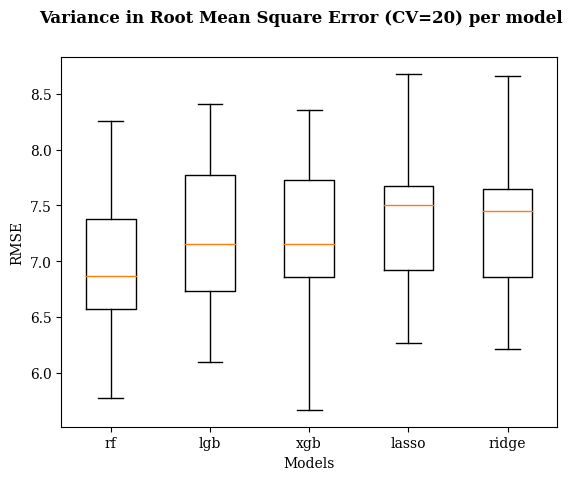

In [27]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()

fig.suptitle('Variance in Root Mean Square Error (CV=20) per model', fontsize=12, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_rmse)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('RMSE')

plt.savefig('RMSE - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))
plt.show()


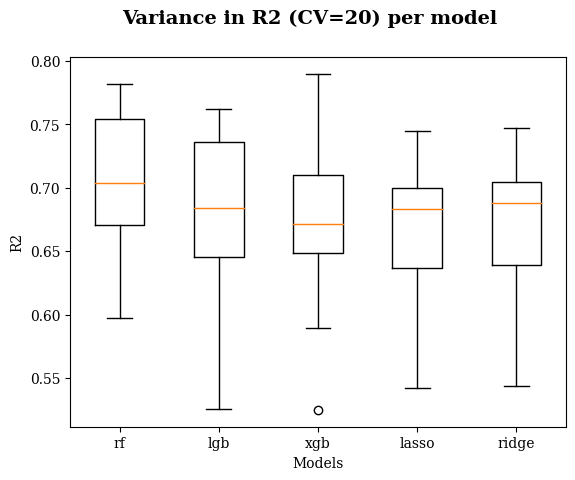

In [28]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()
fig.suptitle('Variance in R2 (CV=20) per model', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_r2)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('R2')

plt.savefig('R2 - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))

plt.show()

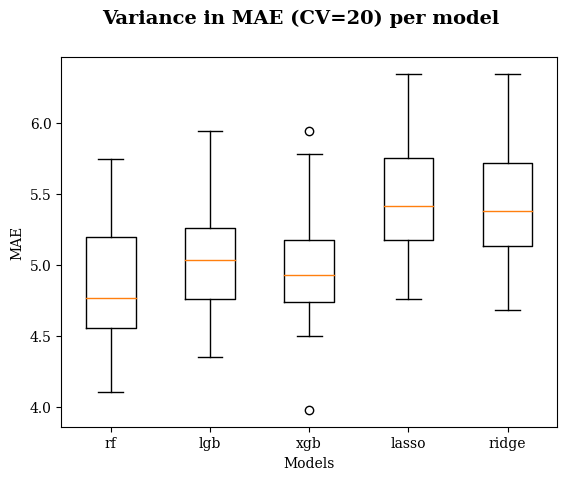

In [29]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()
fig.suptitle('Variance in MAE (CV=20) per model', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_mae)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('MAE')

plt.savefig('MAE - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))

plt.show()